In [10]:
# Load package
import numpy as np; from scipy import stats; import matplotlib.pyplot as plt; import pymc as pm;import arviz as az; 
import math; import pandas as pd
from scipy.optimize import minimize
from scipy import special
import pytensor.tensor as pt
import matplotlib.pyplot as plt

In [11]:
def generate_Corr_identity(p):
    Sigma = np.zeros((p-1, p-1))
    np.fill_diagonal(Sigma, 1)
    return Sigma

def generate_data(n, p, sigma_sqr, beta, nu, corr):

    beta = beta.reshape((p, 1))
    x_i = np.random.normal(0, 1, (n, p - 1))
    x_i_correlated = x_i @ corr
    ones = np.ones((n, 1))
    x_i_full =  np.concatenate((ones, x_i_correlated), axis=1)
    XB = x_i_full @ beta
    E = stats.t.rvs(df = nu, loc=0, scale= np.sqrt(sigma_sqr), size=(n, 1))
    Y = XB + E
    return Y, x_i_full

def negative_log_likelihood_optimize_beta_sigma(params, nu):
    """
    Negative log likelihood that will be passed into minimize function for given nu
    The use of it is to get the numerical result of beta and sigma
    :param params: contains beta and sigma as one vector, dim = p + 1
    :param nu: Degree of freedom
    :param X: Data matrix
    :param y: Observed Value
    :return: The negative log likelihood equation (2) in Fonseca 2008
    """

    betas, sigma = params[:-1], params[-1]
    if sigma <= 0:
        return np.inf  # Return infinity if sigma is non-positive
    p = X.shape[1]
    B = np.reshape(betas, (p, 1))
    XB = X @ B
    n = X.shape[0]
    XB = XB.reshape((n, 1))
    # loglikelihood
    equation = n * np.log(special.gamma((nu + 1)/2)) + n* nu *0.5 * np.log(nu) - n * np.log(special.gamma(nu/2)) - 0.5*n*np.log(np.pi) - n * np.log(sigma) - 0.5 *(nu + 1)*np.sum(np.log(nu + ((y - XB)/sigma)**2))
    return -equation

def optimize_over_nu(nu):
    p = X.shape[1]
    bounds = [(None, None)] * p +[(0, np.inf)]
    initial_guess = np.random.normal(0, 1, size = (p+1))
    initial_guess[p] = np.abs(initial_guess[p])
    result = minimize(negative_log_likelihood_optimize_beta_sigma, initial_guess, args=(nu,), method='Nelder-Mead',bounds= bounds, options={'return_all':True})
    if result.success == False:
        print('optimizer error')
    return [result.x,result.success,result.nit,result.allvecs]

def profile_loglikelihood(nu):
    sigma = optimize_over_nu(nu)[0][-1]
    beta = optimize_over_nu(nu)[0][0:-1]
    p = X.shape[1]
    B = np.reshape(beta, (p, 1))
    XB = X @ B

    #XB = beta1*X[:, 0] + beta2*X[:, 1] + beta3*X[:, 2] + beta4*X[:, 3] + beta5*X[:, 4]
    n = X.shape[0]
    XB = XB.reshape((n, 1))

    eqt = n * np.log(special.gamma((nu + 1)/2)) + n* nu *0.5 * np.log(nu) - n * np.log(special.gamma(nu/2)) - 0.5*n*np.log(np.pi) - n * np.log(sigma) - 0.5 *(nu + 1)*np.sum(np.log(nu + ((y - XB)/sigma)**2))
    return -eqt

def Hess_beta_sigma(beta, sigma, nu, X, y):
    """
    The Hessian matrix of the log likelihood function
    :param beta: Coefficients
    :param sigma: Scale
    :param nu: Degree of freedom
    :param X: Data Matrix
    :param y: Observed Value
    :return: Hessian Matrix of beta and sigma on the log likelihood function, equation (2) Fonseca 2008
    """
    p = X.shape[1]
    n = X.shape[0]
    beta = np.array(beta)
    sigma = np.array(sigma)
    total_b2 = 0
    total_b_sigma = 0
    total_sigma_b = 0
    total_s2 = 0
    for i in range(n):
        Xi = np.reshape(X[i,:], (p, 1))
        residual = y[i] - X[i, :] @ beta
        nu_sigma_sqr_plus_residual =  nu*(sigma**2)+ residual**2
        total_b2 = total_b2 + (- (nu_sigma_sqr_plus_residual)* np.outer(X[i,:],X[i, :]) + np.outer(X[i, :], X[i, :])*2*(residual**2))/(nu_sigma_sqr_plus_residual**2)
        #total_b_sigma = total_b_sigma + (- nu_sigma_sqr_plus_residual*2 * residual * X[i,:] + 2*(residual**3 )*X[i,:]) / (nu_sigma_sqr_plus_residual**2)
        total_sigma_b = total_sigma_b + (-2*nu*sigma*X[i,:]*residual)/(nu_sigma_sqr_plus_residual**2)
        total_s2 = total_s2+ (-(residual**2) * 2* nu ) / ( (nu_sigma_sqr_plus_residual**2)) - 2*(residual**2)/(nu_sigma_sqr_plus_residual* (sigma**2))

    db2 = total_b2 * (nu+1)
    #dbs = total_b_sigma * (nu+1)/sigma
    dsb = total_sigma_b * (nu+1)
    dbs = dsb
    ds2 = n/(sigma**2) + (nu+1)*total_s2

    hessian = np.zeros((p + 1, p + 1))
    hessian[:p, :p] = db2
    hessian[:p, p] = dbs
    hessian[p, :p] = dsb
    hessian[p, p] = ds2

    return hessian

def obs_block_det(beta, sigma, nu, X, y):
    
    block = np.array(Hess_beta_sigma(beta, sigma, nu, X, y))* -1
    
    return np.linalg.det(block)

def adj_profile_loglikelihood(nu):
    sigma = optimize_over_nu(nu)[0][-1]
    beta = optimize_over_nu(nu)[0][0:-1]
    p = X.shape[1]
    B = np.reshape(beta, (p, 1))
    XB = X @ B

    #XB = beta1*X[:, 0] + beta2*X[:, 1] + beta3*X[:, 2] + beta4*X[:, 3] + beta5*X[:, 4]
    n = X.shape[0]
    XB = XB.reshape((n, 1))
    det = obs_block_det(beta, sigma, nu, X, y)

    adj_eqt = n * np.log(special.gamma((nu + 1)/2)) + n* nu *0.5 * np.log(nu) - n * np.log(special.gamma(nu/2)) - 0.5*n*np.log(np.pi) - n * np.log(sigma) - 0.5 *(nu + 1)*np.sum(np.log(nu + ((y - XB)/sigma)**2))-0.5*np.log(abs(det)) 
    return -adj_eqt

# Task 1: dataset from W3
Replicate application in section 5.1 of 
He, D., Sun, D., & He, L. (2021). Objective Bayesian Analysis for the Student-t Linear Regression. Bayesian Analysis, 16(1). https://doi.org/10.1214/20-BA1198

In [173]:
# Sample size
n = 35

# Load data
bond_data = pd.read_csv('U.S. Treasury bond prices (Sheather).csv')

# Predictor
x_1_list = []
for i in range(35):
    x_1_list.append([bond_data['CouponRate'][i]])

ones = np.ones((n, 1))
X =  np.concatenate((ones, x_1_list), axis=1)

# Outcome
y = []
for i in range(35):
    y.append([bond_data['BidPrice'][i]])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


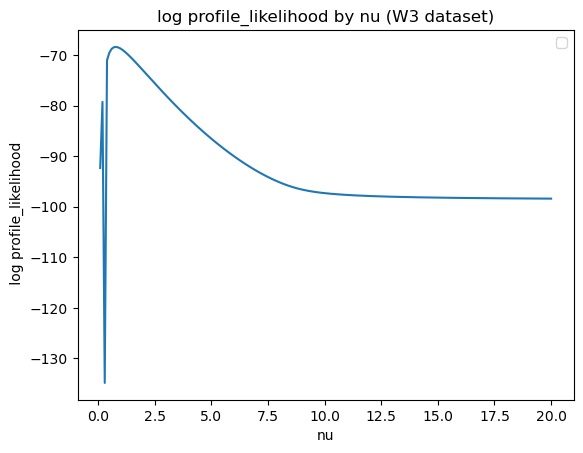

In [174]:
# log Profile likelihood 
nu_list =[]
profile_loglikelihood_list = []

for nu in range(1,201):
    nu = nu/10
    nu_list.append(nu)
    profile_loglikelihood_list.append(- profile_loglikelihood(nu))
    profile_DF = pd.DataFrame({'nu': nu_list,
                        'profile_loglikelihood': profile_loglikelihood_list,
                        })

# Plotting Profile likelihood
plt.plot(profile_DF['nu'], profile_DF['profile_loglikelihood'])
# Adding labels and legend
plt.xlabel('nu')
plt.ylabel(' log profile_likelihood')
plt.title('log profile_likelihood by nu (W3 dataset)')
plt.legend()
# Showing the plot
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


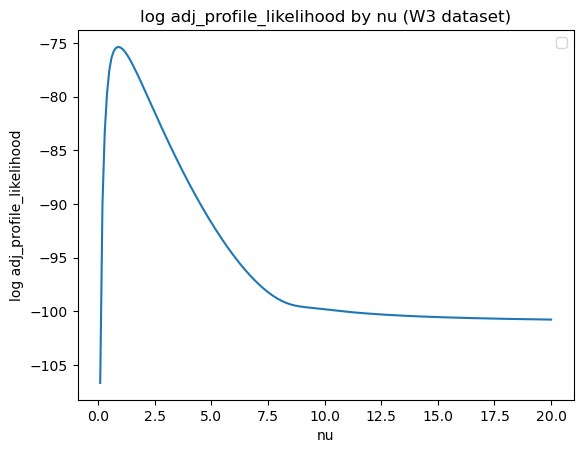

In [177]:
# Adj Profile likelihood 
nu_list =[]
adj_profile_loglikelihood_list = []

for nu in range(1,201):
    nu = nu/10
    nu_list.append(nu)
    adj_profile_loglikelihood_list.append(-adj_profile_loglikelihood(nu))
    adj_DF = pd.DataFrame({'nu': nu_list,
                        'adj_profile_loglikelihood': adj_profile_loglikelihood_list,
                        })
    
# Adj Profile likelihood Plotting
plt.plot(adj_DF['nu'], adj_DF['adj_profile_loglikelihood'])
# Adding labels and legend
plt.xlabel('nu')
plt.ylabel('log adj_profile_likelihood')
plt.title('log adj_profile_likelihood by nu (W3 dataset)')
plt.legend()
# Showing the plot
plt.show()

In [178]:
# Table of optimized beta and sigma for fixed nu
nu_list = []
betas_list = []
sigma_list = []
converge_success_list =[]
iteration_list =[]
for nu in range(1,201,10):
    nu = nu/10
    nu_list.append(nu)
    betas_list.append(optimize_over_nu(nu)[0][:-1])
    sigma_list.append(optimize_over_nu(nu)[0][-1])
    converge_success_list.append(optimize_over_nu(nu)[1])
    iteration_list.append(optimize_over_nu(nu)[2])
    optimized_para_table = pd.DataFrame({'nu': nu_list,
                        'betas': betas_list,
                        'sigma': sigma_list,
                        'converge success':converge_success_list,
                        'converge iteration':iteration_list
                        })
optimized_para_table

optimizer error


,nu,betas,sigma,converge success,converge iteration
0,0.1,"[89.38846118032497, 1.2396514745661493]",0.077640,True,182
1,1.1,"[58.21984848050996, 4.760633196808556]",0.518143,True,237
2,2.1,"[58.4822935855901, 4.728057974503278]",0.762877,True,190
3,3.1,"[58.5936853796562, 4.713023560887419]",0.930845,True,160
4,4.1,"[58.735336803544016, 4.696233204026733]",1.080761,True,221
5,5.1,"[58.970213726113904, 4.670774486745885]",1.238541,True,151
6,6.1,"[59.3661804563428, 4.629534597967492]",1.425047,True,171
7,7.1,"[60.065399655027676, 4.558044660447845]",1.670875,True,164
8,8.1,"[61.442921821155245, 4.418426150888265]",2.038631,True,179
9,9.1,"[64.2699930496876, 4.132807427244908]",2.602071,True,183


# Task 2: Fix nu at true value, optimize beta and nu -> converge? # iterations 

Optimizer: Each iteration print output 

In [17]:
# Generate Data
p = 5 #number of betas
beta = np.array([2, 1, 0.3, 0.9, 1])
n = 1000
nu_origin = 5
sigma_sqr = 1.5
corr = generate_Corr_identity(p)  
y, X = generate_data(n, p, sigma_sqr, beta, nu_origin, corr)

In [18]:
results = optimize_over_nu(nu_origin)
# optimized betas and sigma at true nu
print(results[0])
# successful convergence?
print(results[1])
# number of iteration
print(results[2])

[2.01919957 1.03421104 0.35868125 0.9647897  1.0787246  1.14322812]
True
420


In [21]:
# Each iteration print output
iteration_list = []
betas = []
sigma =[]
for i in range(results[2]):
    iteration_list.append(i+1)
    betas.append(results[3][i][:-1])
    sigma.append(results[3][i][-1])
    iteration_params_table = pd.DataFrame({'iteration': iteration_list,
                        'betas': betas,
                        'sigma': sigma
                        })
iteration_params_table

,iteration,betas,sigma
0,1,"[-1.3040784026588765, -0.6731938651847347, -0....",2.062440
1,2,"[-1.3040784026588765, -0.6731938651847347, -0....",2.165562
2,3,"[-1.3040784026588765, -0.6731938651847347, -0....",2.165562
3,4,"[-1.3040784026588765, -0.6731938651847347, -0....",2.165562
4,5,"[-1.2461193625407039, -0.6607273121257586, -0....",2.184659
...,...,...,...
415,416,"[2.01919005534305, 1.0341432272836, 0.35863063...",1.143212
416,417,"[2.01919005534305, 1.0341432272836, 0.35863063...",1.143212
417,418,"[2.01919005534305, 1.0341432272836, 0.35863063...",1.143212
418,419,"[2.019156693741151, 1.0341356139225795, 0.3586...",1.143252


# Task 3: one covariate

In [3]:
# Generate Data
p = 2 #number of betas
beta = np.array([80,90])
n = 1000
nu_origin = 5
sigma_sqr = 1.5
corr = generate_Corr_identity(p)  
y, X = generate_data(n, p, sigma_sqr, beta, nu_origin, corr)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


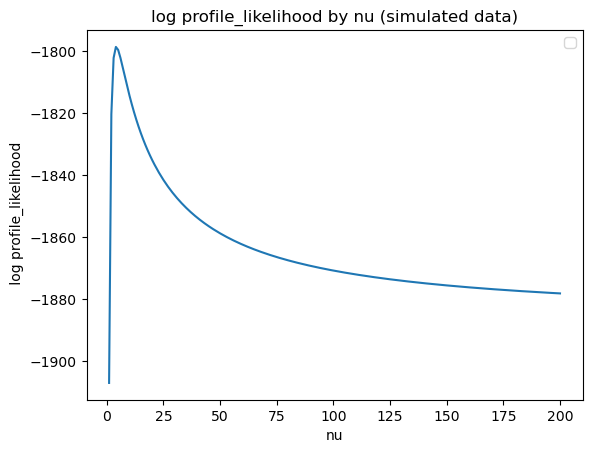

In [4]:
# log Profile likelihood 
nu_list =[]
profile_loglikelihood_list = []

for nu in range(1,201):
    nu = nu
    nu_list.append(nu)
    profile_loglikelihood_list.append(- profile_loglikelihood(nu))
    profile_DF = pd.DataFrame({'nu': nu_list,
                        'profile_loglikelihood': profile_loglikelihood_list,
                        })

# Plotting Profile likelihood
plt.plot(profile_DF['nu'], profile_DF['profile_loglikelihood'])
# Adding labels and legend
plt.xlabel('nu')
plt.ylabel(' log profile_likelihood')
plt.title('log profile_likelihood by nu (simulated data)')
plt.legend()
# Showing the plot
plt.show()

# Task 4: manipulate intitial guess

In [21]:
# Generate Data
p = 5 #number of betas
beta = np.array([20, 10, 30, 90, 15])
n = 1000
nu_origin = 5
sigma_sqr = 1.5
corr = generate_Corr_identity(p)  
y, X = generate_data(n, p, sigma_sqr, beta, nu_origin, corr)

In [22]:
def optimize_over_nu(nu):
    p = X.shape[1]
    bounds = [(None, None)] * p +[(0, np.inf)]
    initial_guess = np.random.normal(10, 1, size = (p+1)) # Change initial guess
    initial_guess[p] = np.abs(initial_guess[p])
    result = minimize(negative_log_likelihood_optimize_beta_sigma, initial_guess, args=(nu,), method='Nelder-Mead',bounds= bounds, options={'return_all':True})
    if result.success == False:
        print('optimizer error')
    return [result.x,result.success,result.nit,result.allvecs]

## MLE

optimizer error
optimizer error


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


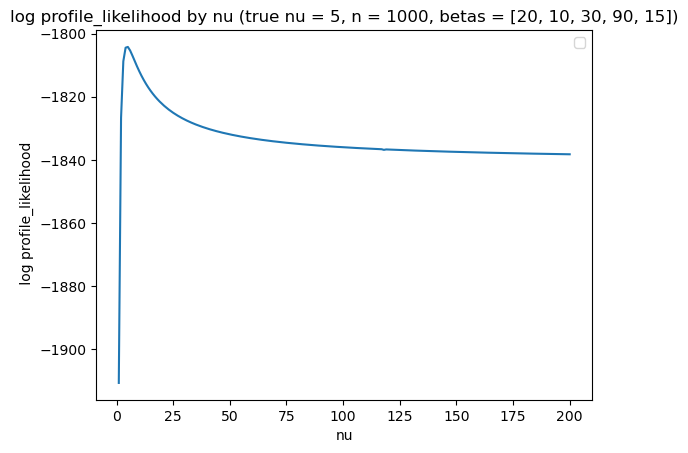

In [23]:
# log Profile likelihood 
nu_list =[]
profile_loglikelihood_list = []

for nu in range(1,201):
    nu = nu
    nu_list.append(nu)
    profile_loglikelihood_list.append(- profile_loglikelihood(nu))
    profile_DF = pd.DataFrame({'nu': nu_list,
                        'profile_loglikelihood': profile_loglikelihood_list,
                        })

# Plotting Profile likelihood
plt.plot(profile_DF['nu'], profile_DF['profile_loglikelihood'])
# Adding labels and legend
plt.xlabel('nu')
plt.ylabel(' log profile_likelihood')
plt.title('log profile_likelihood by nu (true nu = 5, n = 1000, betas = [20, 10, 30, 90, 15])')
plt.legend()
# Showing the plot
plt.show()

In [24]:
minimize(profile_loglikelihood,1,method='Nelder-Mead', bounds = [(0, np.inf)])

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 1804.0713706183078
             x: [ 4.573e+00]
           nit: 22
          nfev: 47
 final_simplex: (array([[ 4.573e+00],
                       [ 4.573e+00]]), array([ 1.804e+03,  1.804e+03]))

In [25]:
np.argmax(profile_DF['profile_loglikelihood']) + 1

5

optimizer error


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


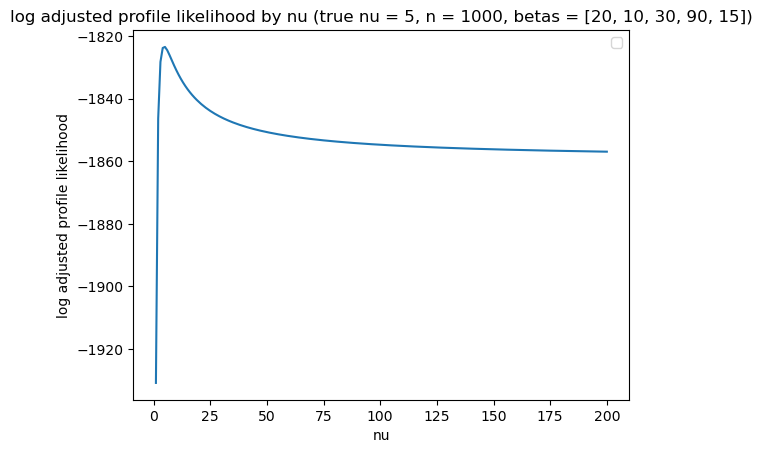

In [26]:
# Adj Profile likelihood Grid search
nu_list =[]
adj_profile_loglikelihood_list = []

for nu in range(1,201):
    nu_list.append(nu)
    adj_profile_loglikelihood_list.append(-adj_profile_loglikelihood(nu))
    adj_DF = pd.DataFrame({'nu': nu_list,
                        'adj_profile_loglikelihood': adj_profile_loglikelihood_list,
                        })
    
# Adj Profile likelihood Plotting
plt.plot(adj_DF['nu'], adj_DF['adj_profile_loglikelihood'])
# Adding labels and legend
plt.xlabel('nu')
plt.ylabel('log adjusted profile likelihood')
plt.title('log adjusted profile likelihood by nu (true nu = 5, n = 1000, betas = [20, 10, 30, 90, 15])')
plt.legend()
# Showing the plot
plt.show()

In [27]:
minimize(adj_profile_loglikelihood,1,method='Nelder-Mead', bounds = [(0, np.inf)])

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 1823.4094595127965
             x: [ 4.608e+00]
           nit: 49
          nfev: 121
 final_simplex: (array([[ 4.608e+00],
                       [ 4.608e+00]]), array([ 1.823e+03,  1.823e+03]))

In [28]:
np.argmax(adj_DF['adj_profile_loglikelihood']) + 1

5

## MAP

In [29]:
# Jeffrey's prior
def logJeff(x):
    return np.log((x/(x+3))**(1/2)*(special.polygamma(1,x/2) - special.polygamma(1, (x+1)/2) - 2*(x+3)/(x*(x+1)**2))**(1/2))

def negative_log_profile_joint(nu):
    return -logJeff(nu) + profile_loglikelihood(nu)

def negative_log_adj_joint(nu):
    return -logJeff(nu) + adj_profile_loglikelihood(nu)

optimizer error
optimizer error


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


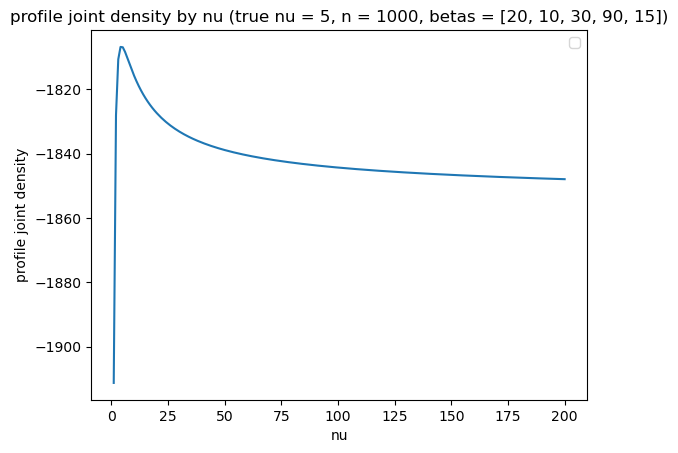

4


       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 1806.6471519488416
             x: [ 4.406e+00]
           nit: 17
          nfev: 37
 final_simplex: (array([[ 4.406e+00],
                       [ 4.406e+00]]), array([ 1.807e+03,  1.807e+03]))

In [30]:
# Profile posterior Grid search
nu_list =[]
profile_post_list = []

for nu in range(1,201):
    nu_list.append(nu)
    profile_post_list.append(logJeff(nu) - profile_loglikelihood(nu)) # Note: profile_loglikelihood returns negative eqt
    profile_post_df = pd.DataFrame({'nu': nu_list,
                        'profile_post_list': profile_post_list,
                        })
    
# Profile posterior Plotting
plt.plot(profile_post_df['nu'], profile_post_df['profile_post_list'])
# Adding labels and legend
plt.xlabel('nu')
plt.ylabel('profile joint density')
plt.title('profile joint density by nu (true nu = 5, n = 1000, betas = [20, 10, 30, 90, 15])')
plt.legend()
# Showing the plot
plt.show()

# MAP grid search
print(np.argmax(profile_post_df['profile_post_list'])+1)

# MAP optimized
minimize(negative_log_profile_joint,nu_origin,method='Nelder-Mead', bounds = [(0, np.inf)])

optimizer error
optimizer error


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


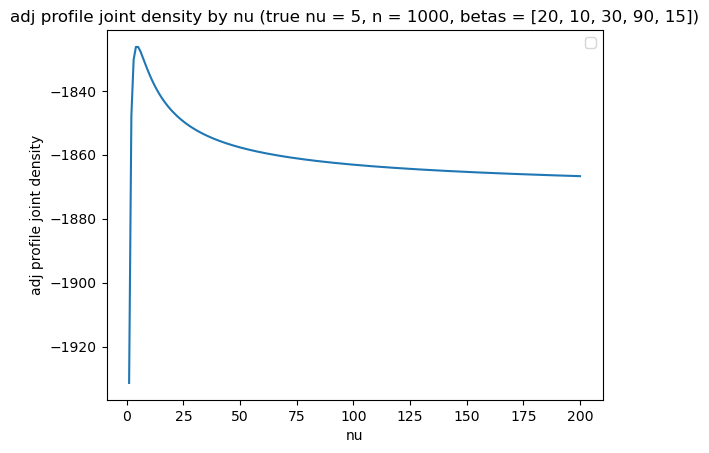

4


       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 1826.0009800759872
             x: [ 4.445e+00]
           nit: 16
          nfev: 37
 final_simplex: (array([[ 4.445e+00],
                       [ 4.445e+00]]), array([ 1.826e+03,  1.826e+03]))

In [31]:
# Adj Profile posterior Grid search
nu_list =[]
adj_profile_post_list = []

for nu in range(1,201):
    nu_list.append(nu)
    adj_profile_post_list.append(logJeff(nu) - adj_profile_loglikelihood(nu)) # Note: profile_loglikelihood returns negative eqt
    adj_profile_post_df = pd.DataFrame({'nu': nu_list,
                        'adj_profile_loglikelihood': adj_profile_post_list,
                        })
    
# Profile posterior Plotting
plt.plot(adj_profile_post_df['nu'], adj_profile_post_df['adj_profile_loglikelihood'])
# Adding labels and legend
plt.xlabel('nu')
plt.ylabel('adj profile joint density')
plt.title('adj profile joint density by nu (true nu = 5, n = 1000, betas = [20, 10, 30, 90, 15])')
plt.legend()
# Showing the plot
plt.show()

# adj MAP grid search
print(np.argmax(adj_profile_post_df['adj_profile_loglikelihood'])+1)

# adj MAP optimized
minimize(negative_log_adj_joint,nu_origin,method='Nelder-Mead', bounds = [(0, np.inf)])